## Instaling KQLmagic libraries

In [ ]:
!pip3 install Kqlmagic --no-cache-dir --upgrade

## Loading the KQLmagic library

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


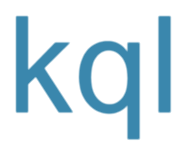

In [1]:
%reload_ext Kqlmagic

## Configuring KQLmagic

In [2]:
%config Kqlmagic.auto_dataframe=True
%config Kqlmagic.auto_popup_schema=True
# %config Kqlmagic.display_limit=10

## Importing python libraries

In [3]:
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = False

<h2 align='center'>=========================================================</h2>

## Connecting to a private Log Analytics
**ATTENTION:** edit and change the name of `config_file_example.py` to `config_file.py`. Note that `config_file.py` will not be pushed to Github because it contains sensitive information (and it is in `.gitignore``)

In [4]:
from config_file import *

In [5]:
%kql loganalytics://tenant=$conf_tenant_id;clientid=$conf_aad_appid;clientsecret=$conf_aad_appkey;workspace=$conf_workspace_id

<IPython.core.display.Javascript object>

<h2 align='center'>=========================================================</h2>

## in 'SigninLogs', manually determining which columns contain sensitive information

- **'TenantId' = TRUE**
- 'SourceSystem'
- 'TimeGenerated'
- **'ResourceId' = TRUE**
- 'OperationName'
- 'OperationVersion'
- 'Category'
- 'ResultType'
- 'ResultSignature'
- 'ResultDescription'
- 'DurationMs'
- 'CorrelationId'
- 'Resource'
- 'ResourceGroup'
- 'ResourceProvider'
- **'Identity' = TRUE**
- 'Level'
- **'Location' = TRUE**
- **'AlternateSignInName' = SOMETIMES**
- '**AppDisplayName'= SOMETIMES**
- 'AppId'
- 'AuthenticationDetails'
- 'AuthenticationMethodsUsed'
- 'AuthenticationProcessingDetails'
- 'AuthenticationRequirement'
- 'AuthenticationRequirementPolicies'
- 'ClientAppUsed'
- 'ConditionalAccessPolicies'
- 'ConditionalAccessStatus'
- 'CreatedDateTime'
- 'DeviceDetail'
- 'IsInteractive'
- 'Id'
- **'IPAddress' = TRUE**
- 'IsRisky'
- **'LocationDetails' = TRUE**
- 'MfaDetail'
- 'NetworkLocationDetails'
- **'OriginalRequestId' = TRUE**
- 'ProcessingTimeInMilliseconds'
- 'RiskDetail'
- 'RiskEventTypes'
- 'RiskEventTypes_V2'
- 'RiskLevelAggregated'
- 'RiskLevelDuringSignIn'
- 'RiskState'
- 'ResourceDisplayName'
- **'ResourceIdentity' = TRUE**
- 'ServicePrincipalId'
- 'ServicePrincipalName'
- 'Status'
- 'TokenIssuerName'
- 'TokenIssuerType'
- 'UserAgent'
- **'UserDisplayName' = TRUE**
- **'UserId' = TRUE**
- **'UserPrincipalName' = TRUE**
- **'AADTenantId' = TRUE**
- 'Type'

## Manually anonymizing 1 single entry of each sensitive field

In [7]:
import uuid, names,random, pycountry

In [8]:
fake_domainname = 'mycompany.com'

TenantId=str(uuid.uuid4())
AADTenantId = str(uuid.uuid4())
ResourceId='/tenants/'+AADTenantId+'/providers/Microsoft.aadiam'
Identity = names.get_full_name()
UserDisplayName = Identity
UserPrincipalName = Identity.lower().replace(' ','.')+'@'+fake_domainname
Location = list(pycountry.countries)[random.randint(0,248)].alpha_2
LocationDetails = '{'+'\'countryOrRegion\':\''+Location+'\'}'
IPAddress = ".".join(map(str, (random.randint(0, 255) for _ in range(4))))
OriginalRequestId = str(uuid.uuid4())
ResourceIdentity = str(uuid.uuid4())
UserId = str(uuid.uuid4())

print(TenantId, ResourceId, Identity, Location, IPAddress, LocationDetails, OriginalRequestId, ResourceIdentity, UserDisplayName, UserId, UserPrincipalName, AADTenantId)

425dc03a-3cdc-42e7-884b-09bf02157895 /tenants/2e42acc6-619f-4cb7-98eb-4909abdbaeea/providers/Microsoft.aadiam Andre Zeman BF 65.176.224.16 {'countryOrRegion':'BF'} e86521a6-2dbf-4465-a3b3-830c5c031999 f4917825-5289-4de1-b1c3-bfc8c74296e7 Andre Zeman 9fe9da09-5f63-4ccb-bd48-0b43fc6047b0 andre.zeman@mycompany.com 2e42acc6-619f-4cb7-98eb-4909abdbaeea


<h2 align='center'>=========================================================</h2>

## Getting the original data

In [6]:
df = %kql workspace("<loganalytics-workspace>").SigninLogs | where TimeGenerated > ago(30d) 

<h2 align='center'>=========================================================</h2>

## Script to anonymizing each sensitive field
### Methodology:
1. get len of unique values;
2. create a simmilar set with the same lenght of the set with unique values;
3. substitute the new set for the original set;

In [30]:
import uuid, names,random, pycountry

In [31]:
fake_domainname = 'mycompany.com'
fake_companyname = 'My Company'
original_company_name = '<COMPANY-NAME>' #PRIVATE

In [32]:
df_anon = df

In [33]:
column_name = 'AADTenantId'

list_names = df_anon[column_name].unique().tolist()
unique_values = len(list_names)

lists = []
for p in range(unique_values):
    lists.append(str(uuid.uuid4()))

substitution_mask = pd.concat([pd.Series(df_anon[column_name].unique()), pd.Series(lists)], axis=1, sort=False)
df_anon = pd.merge(df_anon, substitution_mask, how='inner', left_on=column_name, right_on=0,sort=False).drop([0, column_name], axis=1).rename(columns={1: column_name})

In [34]:
df_anon['ResourceId']=df_anon['AADTenantId'].apply(lambda x: '/tenants/'+str(x)+'/providers/Microsoft.aadiam')

In [35]:
column_name = 'TenantId'

list_names = df_anon[column_name].unique().tolist()
unique_values = len(list_names)

lists = []
for p in range(unique_values):
    lists.append(str(uuid.uuid4()))

substitution_mask = pd.concat([pd.Series(df_anon[column_name].unique()), pd.Series(lists)], axis=1, sort=False)
df_anon = pd.merge(df_anon, substitution_mask, how='inner', left_on=column_name, right_on=0,sort=False).drop([0, column_name], axis=1).rename(columns={1: column_name})

In [36]:
column_name = 'Identity'

list_names = df_anon[column_name].unique().tolist()
unique_values = len(list_names)

lists = []
for p in range(unique_values):
    lists.append(names.get_full_name())

substitution_mask = pd.concat([pd.Series(df_anon[column_name].unique()), pd.Series(lists)], axis=1, sort=False)
df_anon = pd.merge(df_anon, substitution_mask, how='inner', left_on=column_name, right_on=0,sort=False).drop([0, column_name], axis=1).rename(columns={1: column_name})

In [37]:
df_anon['UserDisplayName']=df_anon['Identity']

In [38]:
df_anon['UserPrincipalName'] = df_anon['Identity'].apply(lambda x: x.lower().replace(' ','.')+'@'+fake_domainname)

In [39]:
df_anon['AlternateSignInName'] = df_anon['UserPrincipalName']

In [40]:
column_name = 'Location'

list_names = df_anon[column_name].unique().tolist()
unique_values = len(list_names)

lists = []
for p in range(unique_values):
    lists.append(list(pycountry.countries)[random.randint(0,248)].alpha_2)

substitution_mask = pd.concat([pd.Series(df_anon[column_name].unique()), pd.Series(lists)], axis=1, sort=False)
df_anon = pd.merge(df_anon, substitution_mask, how='inner', left_on=column_name, right_on=0,sort=False).drop([0, column_name], axis=1).rename(columns={1: column_name})

In [41]:
df_anon['LocationDetails'] = df_anon['Location'].apply(lambda x: '{'+'\'countryOrRegion\':\''+str(x)+'\'}')

In [42]:
column_name = 'IPAddress'

list_names = df_anon[column_name].unique().tolist()
unique_values = len(list_names)

lists = []
for p in range(unique_values):
    lists.append(".".join(map(str, (random.randint(0, 255) for _ in range(4)))))

substitution_mask = pd.concat([pd.Series(df_anon[column_name].unique()), pd.Series(lists)], axis=1, sort=False)
df_anon = pd.merge(df_anon, substitution_mask, how='inner', left_on=column_name, right_on=0,sort=False).drop([0, column_name], axis=1).rename(columns={1: column_name})

In [43]:
column_name = 'OriginalRequestId'

list_names = df_anon[column_name].unique().tolist()
unique_values = len(list_names)

lists = []
for p in range(unique_values):
    lists.append(str(uuid.uuid4()))

substitution_mask = pd.concat([pd.Series(df_anon[column_name].unique()), pd.Series(lists)], axis=1, sort=False)
df_anon = pd.merge(df_anon, substitution_mask, how='inner', left_on=column_name, right_on=0,sort=False).drop([0, column_name], axis=1).rename(columns={1: column_name})

In [44]:
column_name = 'ResourceIdentity'

list_names = df_anon[column_name].unique().tolist()
unique_values = len(list_names)

lists = []
for p in range(unique_values):
    lists.append(str(uuid.uuid4()))

substitution_mask = pd.concat([pd.Series(df_anon[column_name].unique()), pd.Series(lists)], axis=1, sort=False)
df_anon = pd.merge(df_anon, substitution_mask, how='inner', left_on=column_name, right_on=0,sort=False).drop([0, column_name], axis=1).rename(columns={1: column_name})

In [45]:
column_name = 'UserId'

list_names = df_anon[column_name].unique().tolist()
unique_values = len(list_names)

lists = []
for p in range(unique_values):
    lists.append(str(uuid.uuid4()))

substitution_mask = pd.concat([pd.Series(df_anon[column_name].unique()), pd.Series(lists)], axis=1, sort=False)
df_anon = pd.merge(df_anon, substitution_mask, how='inner', left_on=column_name, right_on=0,sort=False).drop([0, column_name], axis=1).rename(columns={1: column_name})

In [46]:
df_anon['AppDisplayName'] = df_anon['AppDisplayName'].apply(lambda x: x.replace(original_company_name,fake_companyname) )

## Exporting the data

In [49]:
df_anon.sort_values(by='TimeGenerated').to_csv('30days_anonymized_sigin_logs.csv')